# Basic usage of the DFSZforest package
© Johannes Diehl

Compute anomaly ratios for different DFSZ-type models. This code has been used for the paper [*DFSZ axions and where to find them*](https://arxiv.com) by [Emmanouil Koutsangelas]() and [Johannes Diehl](https://scholar.google.com/citations?hl=en&user=BrHSTFwAAAAJ). The data files included can also be found separately on [Zenodo](https://zenodo.org).

In [28]:
using StaticArrays
using Symbolics
using Combinatorics
using LinearAlgebra
using HDF5, FileIO, JLD2

path = "./src/"
include(path*"drawer.jl")
include(path*"ksvz.jl")
include(path*"helpers.jl")
include(path*"constructors.jl")
include(path*"LSEsolvers.jl")
include(path*"runners.jl")
include(path*"savers.jl")
include(path*"analysers.jl")


@variables u1::Int u2::Int u3::Int d1::Int d2::Int d3::Int l1::Int l2::Int l3::Int ;

## Understanding a single Yukawa sector

Let us first understand how to handle one Yukawa sector on its own, before moving on to calculate anomaly ratios for many different models in bulk.

Start by defining a Yukawa sector:

In [29]:
yukawa = [u1,u1,u3,d1,d1,d3,l1,l1,l1];

We have just defined one specific Yukawa sector with five Higgs doublets $n_D=5$.
To calculate anomaly ratios we need to specify the explicit symmetry breaking potential. To do this we need bilinears and quadrilinears. We get them using

In [3]:
bilins = get_bilins(yukawa)

20-element Vector{Num}:
  u1 - u3
  d1 + u1
  d3 + u1
  l1 + u1
  d1 + u3
  d3 + u3
  l1 + u3
  d1 - d3
  d1 - l1
  d3 - l1
  u3 - u1
 -d1 - u1
 -d3 - u1
 -l1 - u1
 -d1 - u3
 -d3 - u3
 -l1 - u3
  d3 - d1
  l1 - d1
  l1 - d3

In [4]:
quads, qmultis = get_quads(yukawa)

(Num[l1 + 2u1 - u3, 2d3 + 2u1, l1 + u3 - d1 - u1, 2l1 - 2d1, u3 + 2d1 - d3, u3 + 2d3 - l1, d1 + 2u3 - u1, d1 + l1 + u3 - d3, l1 + 2u3 - u1, 2l1 + 2u1  …  u1 + 2d3 - d1, d3 + l1 + 2u3, 2d3 + 2u3, d3 + l1 + u1 + u3, 2l1 - 2d3, d1 + l1 + u1 + u3, u1 + u3 + 2l1, d3 + 2u1 - u3, d1 + d3 + u1 - l1, u1 + 2d1 - l1], [1, 4, 2, 4, 1, 1, 1, 2, 1, 4  …  1, 1, 4, 2, 4, 2, 1, 1, 2, 1])

What we got here is not potential terms, but rather the conditions on the fermion/ Higgs doublet charges corresponding to the specific potential terms. Note that while in the definition of the yukawa sector e.g. `u1` stood for the Higgs doublet, i.e. H<sub>u<sub>1</sub></sub>, it now stands for the respective charge. So `u1` now means $\chi$<sub>u<sub>1</sub></sub>.

We use these conditions together with the orthogonality relation to find which combination of conditions allows for which values in PQ charges. Let us assume we found `u1 = 1`, `u3 = 3.5`, `d1 = 2`, `d3 = 0` and `l1 = 1`. We can then calculate the anomalies as well as the anomaly ratio.

In [5]:
Nf = get_Nfunc(yukawa)
Nf([1,1.5,2,0,1]) == N([1,1,1.5,2,2,0,1,1,1]...) == 3.75

true

In [6]:
EoNf = get_EoNfunc(yukawa)
EoNf([1,1.5,2,0,1]) == EoverN([1,1,1.5,2,2,0,1,1,1]...) == 2.4

true

But hold up! If `N = 3.75` and $N_{DW} = 2 N$, then $N_{DW} = 7.5$. This is impossible! $N_{DW}$ has to be integer! So what is going on?

If we write `u1 = 1` this implies units of the charge of the Higgs singlet $\chi_s$. The anomaly ratio itself is independent of $\chi_s$, but $E$ or $N$ are not. We therefore see that in our little example $\chi_s = 1$ is impossible, $\chi_s = 2$ has to be chosen!

## Calculating all $n_D = 4$ models, output everything

We can now move on to actually doing the calculation of the charges!

In [7]:
fold = "./data/DFSZ_models/"
dataset = "test";

The code below will compute all models for $n_D = 4$ and write the results into a h5 and a human readable textfile like the ones provided with the package. If the folder `dataset` does not exist, it will create a new one. Execution should take O(1 minute).

In [ ]:
models, mmultis = model_list(nD=[4])
runDFSZ_saveall(dataset, models; model_multiplicity=mmultis);
h5totxt("full_n4"; folder=fold*dataset*"/")

Have a look at the resulting textfile!

We can now do various analyses with the data, for example:

In [35]:
fid = h5open(fold*dataset*"/full_n4.h5")

EoNs = []
mychi = Matrix{Float64}(undef,0,10)
tot = 0 

for (i, a) in enumerate(fid)
    k = read(a)
    if i != 1
        println(keys(fid)[i])
        for tuple in k#collect(values(k))
            dat = tuple[2]
            tot += sum(dat["model_multiplicity"] .* dat["multis"])
            mychi = vcat(mychi, round.(dat["Chis"], digits=5))
            append!(EoNs, round.(dat["EoN"], digits=5))
        end
    end
end

close(fid)

The h5 file has the following fields (in order of the columns of the txt file):
`model_multiplicity`, `multis`, `EoN`, `E`, `N`, `Chis` and `terms`.

The total number of models that have a solution

In [12]:
tot

52614

The unique solutions for the PQ charges

In [13]:
unique(eachrow(mychi))

996-element Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [0.0, 0.0, 0.0, -2.0, -2.0, -2.0, 2.0, 2.0, 0.0, 1.0]
 [-0.75, -0.75, -0.75, -1.25, -1.25, -1.25, 0.75, 0.75, -0.25, 1.0]
 [-0.5, -0.5, -0.5, -1.5, -1.5, -1.5, 0.5, 0.5, 0.5, 1.0]
 [-0.5, -0.5, -0.5, -1.5, -1.5, -1.5, 1.5, 1.5, -0.5, 1.0]
 [-0.5, -0.5, -0.5, -1.5, -1.5, -1.5, 1.16667, 1.16667, -0.16667, 1.0]
 [-1.5, -1.5, -1.5, -0.5, -0.5, -0.5, -2.5, -2.5, 1.5, 1.0]
 [-1.5, -1.5, -1.5, -0.5, -0.5, -0.5, -1.5, -1.5, 0.5, 1.0]
 [-1.5, -1.5, -1.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 1.0]
 [-3.0, -3.0, -3.0, 1.0, 1.0, 1.0, -3.0, -3.0, -1.0, 1.0]
 [-0.5, -0.5, -0.5, -1.5, -1.5, -1.5, 4.5, 4.5, -3.5, 1.0]
 ⋮
 [-1.5, -1.5, -3.5, -0.5, -0.5, -0.5, -4.5, -4.5, -4.5, 3.0]
 [-1.5, -1.5, 0.5, 3.5, 3.5, 3.5, -4.5, -4.5, -4.5, 3.0]
 [-1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 1.0]
 [-2.25, -2.25, -0.25, -0.75, -0.75, -0.75, -1.75, -1.75, -1.75, 2.0]
 [-1.75, -1.75, 0.25, 0.75, 0.75,

The unique values for the anomaly ratio for this number of Higgs doublets

In [14]:
unique(EoNs)

83-element Vector{Any}:
 -0.66667
  1.0
  0.66667
  0.33333
  0.44444
  3.33333
  3.0
  2.66667
  6.0
  2.0
  ⋮
 -1.83333
 20.66667
 -2.13333
 -0.7619
  2.06667
  1.57576
  0.41667
  0.86667
  5.06667

## Calculating all $n_D = 4$ models, output anomaly ratio countmap

Going to bigger $n_D$ there are far too many possible combinations of bilinears and quadrilinears to print out all of these models in the way shown above. But the number of unique anomaly ratios grows only slowly. We therefore use countmaps to be able to store the most important information, the distribution of anomaly ratios. Unfortunately this makes a connection between the specific potentials, PQ charge solutions and anomaly ratios impossible.

In [ ]:
models, multis = model_list(nD=[4])
runDFSZ(dataset, models; model_multiplicity=multis, same_χH_one_theory=true, NDW1=false, filename="testEoNs")

Let's have a look what we just produced here! The `read_EoN` function gives a countmap including the results for all `models`.

In [21]:
e1=read_EoN(dataset, models; specifier="testEoNs")

Dict{Any, Float64} with 84 entries:
  2.91667   => 24.0
  5.16667   => 18.0
  2.66667   => 150.0
  18.6667   => 24.0
  0.888889  => 24.0
  1.86667   => 60.0
  0.666667  => 150.0
  3.86667   => 42.0
  1.57576   => 24.0
  6.0       => 42.0
  12.6667   => 30.0
  2.38095   => 18.0
  1.77778   => 18.0
  0.266667  => 30.0
  1.80952   => 18.0
  4.0       => 60.0
  -4.0      => 24.0
  -1.33333  => 36.0
  -15.3333  => 24.0
  ⋮         => ⋮

We can now analyse this. First, let us check if we did everything right. If we did, the distribution of `e1` has to be symmetric around 5/3.

In [22]:
check_symmetry(e1)

true

We can also look at the distribution in a nice simple plot

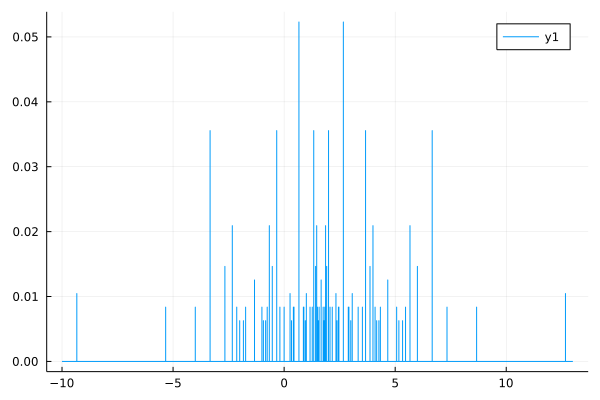

In [25]:
using Plots
plot()
plot_EoN(e1)

or analyse it in any other way:

In [26]:
ke1 = collect(keys(e1));
ve1 = collect(values(e1));
ve1 = ve1[isnan.(ke1) .== 0];
ke1 = ke1[isnan.(ke1) .== 0];

## Calculating $n_D = 7$ models, sampling

Above $n_D = 6$, the number of models to calculate could become prohibitive. Unfortunately sampling in this case is only possible when same_$\chi$H_one_theory`=false`. In this case it works well however and therefore we present it here. This may take a while.

In [ ]:
# Suitable sample_models_factor for not too extensive runtimes (Order of hours)
# n=7 -> 0.001
# n=8 -> 0.000001
# n=9 -> 0.000000001
models, multis = model_list(nD=[7])
runDFSZ(dataset, models; model_multiplicity=multis, log_calculate_all_models_if_below=3, sample_models_factor=0.00001, same_χH_one_theory=false, NDW1=false, filename="testEoNs_sample")